<a href="https://colab.research.google.com/github/DaniyalK03/HPC/blob/main/HPC_Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Techniques of High-Performance Computing (Assignment 3)

**Submission by SN: 21015796**

## Introduction

The following notebook is submitted coursework for PHAS0102.

This notebook utilises various libraries and classes from Object Oriented Programming to compare performance of sparse matrix based solvers to existing Numpy solvers.


*  In **Part 1**, a class is set up to take COO matrices and initialise them as CSR matrices with matrix addition and matrix-vector multiplication functions defined. The matvec product is compared to the Numpy matvec product, which uses dense matrices, and the timings for the functions when tested on varying sizes of randomised matrices are plotted. The timing structure is adapted from an earlier coursework self submission (See [2]).

*   In **Part 2**, another class is set up to initialise matrices as a particular custom matrix structure (See [1]). Matrix-Vector multiplication function is also defined in this class in an efficient manner to compute results for these types of matrices effectively. Again, this matvec product is compared to the Numpy matvec product and the timings for the functions when tested on varying sizes of randomised matrices are plotted.

### Bibliography

**[1]** A. Al-Refaie, "Assignment 2", *PHAS0102*, 2024

**[2]** 21015796, "Coursework 1", *PHAS0102*, 2024

## Part 1

In [ ]:
#####################################################################################################################################################

# Importing backend libraries as necessary

import numpy as np
import matplotlib.pyplot as plt
import scipy
import numba

from numba import cuda
from numpy.random import default_rng
from timeit import timeit
from scipy.sparse import coo_matrix, csr_matrix, linalg, diags
from scipy.stats import linregress
from scipy.sparse.linalg import cg,gmres
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng

In [ ]:
# Adapted below from [1]

from scipy.sparse.linalg import LinearOperator


class CSRMatrix(LinearOperator):
    def __init__(self, coo_matrix):
        """
        Initialises a COO matrix to CSR matrix form.
        """

        # Defining variables.
        self.shape = coo_matrix.shape
        self.dtype = coo_matrix.dtype


        rows, cols = coo_matrix.row, coo_matrix.col

        self.data = coo_matrix.data
        self.indices = cols
        self.indptr = np.zeros(self.shape[0] + 1, dtype=np.int32)

        for i in rows:
            self.indptr[i + 1] += 1
        self.indptr = np.cumsum(self.indptr) # np.cumsum for quick indptr update.


    def __add__(self, other):
        """Add the CSR matrix other to this matrix."""
        assert other.shape == self.shape # This ensures that only matrices of same shape are added.

        # Set up for the self matrix components.
        rows1 = []
        cols1 = self.indices

        data1 = self.data
        indices1 = cols1
        indptr1 = self.indptr

        for i in range(len(indptr1) - 1):
            rows1.extend([i] * (indptr1[i + 1] - indptr1[i]))
        rows1 = np.array(rows1, dtype=np.int32)

        # Set up for the other matrix components.
        rows2 = []
        cols2 = other.indices

        data2 = other.data
        indices2 = cols2
        indptr2 = other.indptr

        for i in range(len(indptr2) - 1):
            rows2.extend([i] * (indptr2[i + 1] - indptr2[i]))
        rows2 = np.array(rows2, dtype=np.int32)

        # Combining components for resulting matrix.
        result_rows = np.concatenate((rows1, rows2)).astype(np.int32)
        result_cols = np.concatenate((cols1, cols2)).astype(np.int32)
        result_data = np.concatenate((data1, data2)).astype(np.float64)

        result_coo = coo_matrix((result_data, (result_rows, result_cols)), shape=self.shape)
        result_coo.sum_duplicates() # This is to avoid errors.

        return CSRMatrix(result_coo)

    def _matvec(self, vector):
        """Compute a matrix-vector product."""
        assert self.shape[1] == vector.shape[0] # Only allow matrix multiplication between m x n * n x p dimensions.

        result = np.zeros(self.shape[0], dtype = self.dtype) # Initialise for results to be added into.

        for row_ind in range (self.shape[0]):
          for col_ind in range (self.indptr[row_ind], self.indptr[row_ind + 1]):
            result[row_ind] += self.data[col_ind] * vector[self.indices[col_ind]]

        return result

In [ ]:
def test_csr_matrix():

    """
    Setting up assert to test that the matrix setup, addition, multiplication functions work.
    """

    # Generate a random COO matrix
    mat1 = scipy.sparse.random(10,10,density=0.10)

    mat1_coo = coo_matrix(mat1)
    mat1_csr = CSRMatrix(mat1_coo) # CSR form

    # Generate another random COO matrix
    mat2 = scipy.sparse.random(10,10, density=0.10)

    mat2_coo = coo_matrix(mat2)
    mat2_csr = CSRMatrix(mat2_coo) # CSR form

    # Result Matrix
    mat_sum = mat1 + mat2
    mat_sum_dense = mat_sum.toarray()

    mat_sum_csr = mat1_csr + mat2_csr
    mat_sum_csr_output = csr_matrix((mat_sum_csr.data,mat_sum_csr.indices,mat_sum_csr.indptr), shape = mat1.shape).toarray()

    # Assert test for addition
    assert np.allclose(mat_sum_dense, mat_sum_csr_output)


    # Generate a random vector
    vec1 = np.random.rand(10) # Same size as random matrix

    # Result Vector
    mat_mul = mat1 @ vec1

    mat_mul_csr = mat1_csr @ vec1

    # Assert test for matrix-vector multiplication
    assert np.allclose(mat_mul, mat_mul_csr)

    print("All tests passed with random inputs.")


In [ ]:
def csr_matvec(csr, vec):
    """
    Defining function using csr matvec to call later
    """
    return csr @ vec

def dense_matvec(dense, vec):
    """
    Defining function using Numpy matvec to call later
    """
    return np.matmul(dense,vec)

def measure_matvec():

    """
    Setting up timer to compare matvec times across randomised matrices of varying dimensions.
    """

    sizes = np.logspace(1,4,num=100).astype(int)
    density = 0.01  # Sparsity level

    # Initialise arrays to store timing results
    csr_time_means = []
    csr_time_stds = []
    dense_time_means = []
    dense_time_stds = []

    for size in sizes:

        # Generate a random sparse matrix in COO format
        coo = scipy.sparse.random(size, size, density=density, format="coo")
        csr = CSRMatrix(coo)
        dense = coo.toarray() # Dense for Numpy use

        # Generate a random vector
        vec = np.random.rand(size) # Same size as matrix

        # Measure time for CSR and Numpy matvec. Using 5 loops across 3 runs.
        func1_time = %timeit -o -q -n 5 -r 3 csr_matvec(csr, vec)
        func2_time = %timeit -o -q -n 5 -r 3 dense_matvec(dense, vec)

        # Appending the average times per loop and standard deviations
        csr_time_means.append(func1_time.average)
        csr_time_stds.append(func1_time.stdev)
        dense_time_means.append(func2_time.average)
        dense_time_stds.append(func2_time.stdev)


    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.errorbar(sizes, csr_time_means, yerr=csr_time_stds, label="CSRMatrix matvec product", fmt="o-")
    plt.errorbar(sizes, dense_time_means, yerr=dense_time_stds, label="Numpy matvec product", fmt="x-")
    plt.xlabel("Matrix Size - N x N")
    plt.ylabel("Time (seconds)")
    plt.title("Performance Comparison: CSRMatrix vs Numpy Matvec")
    plt.legend()
    plt.grid()
    plt.show()

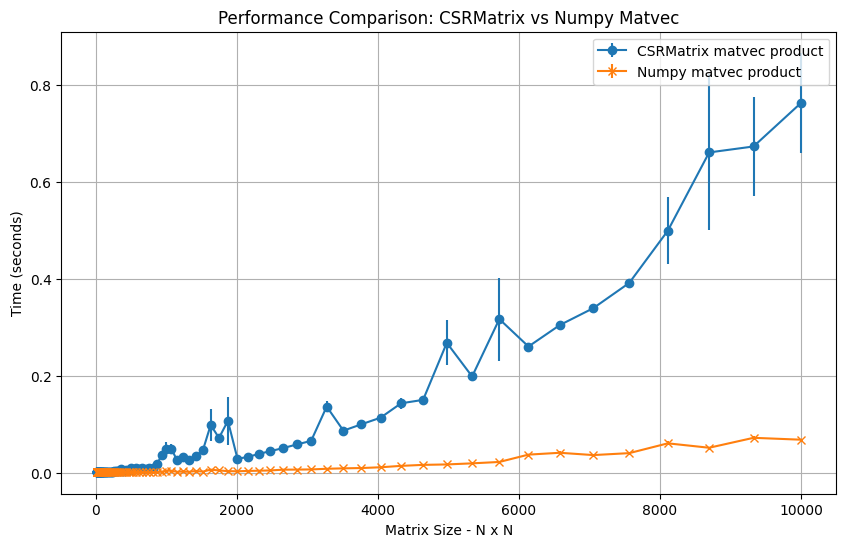

In [ ]:
measure_matvec()

It can be seen above that the Numpy matvec product is much quicker than the CSRMatrix version created. The difference is attributed to the use of specialised libraries and the structures of the functions used:


*   The CSRMatrix function uses a double nested for loop structure - a for loop embedded within a for loop - hence time complexity **O($n^2$)**.
*   The Numpy function utilises BLAS and LAPACK libraries, scaling linearly for time complexity and thus being efficient for larger dimensional matrices.



In [ ]:
def solve_gmres_cg():

    """
    Tests a 10 x 10 random matrix when solved with GMRES and CG.
    """

    # Generate a random sparse matrix (size 10x10 for brevity here)
    size = 10
    density = 0.5 # Can be changed

    coo = scipy.sparse.random(size, size, density=density, format='coo')
    csr = CSRMatrix(coo)

    A_dense = coo.toarray()
    A_coo = coo_matrix(A_dense)
    csr_test = CSRMatrix(A_coo)

    # Generate a random vector b
    b = np.random.rand(size) # Same size as matrix

    # Solve using GMRES
    gmres_sol, gmres_info = gmres(csr_test, b)
    print(f"GMRES Solution: {gmres_sol}")
    print(f"GMRES Info (convergence value to true solution): {gmres_info}")

    # Solve using CG
    cg_sol, cg_info = cg(csr_test, b)
    print(f"CG Solution: {cg_sol}")
    print(f"CG Info (convergence value to true solution): {cg_info}")

    # Compare the solutions
    solutions_similarity = np.allclose(gmres_sol, cg_sol)
    print(f"Solutions approximately identical: {solutions_similarity}")


In [ ]:
# Compare the methods, convergence at info = 0
solve_gmres_cg()

GMRES Solution: [  2.073673     0.17252981  10.63482164   3.00442643   3.43246339
   1.8283529   -6.61855822 -15.02275712 -28.50363543  -0.26494925]
GMRES Info (convergence value to true solution): 0
CG Solution: [-7110.40143387 -7470.90504124  2987.82279328  2156.59699404
 -2732.58077596  3131.995135    1343.22666106  1504.92636713
 -1190.59551823  -138.74798904]
CG Info (convergence value to true solution): 100
Solutions approximately identical: False


It can be seen that GMRES is a relatively good approximation for the true solution. CG is a very poor approximation for the true solution.
This is expected as CG requires a symmetric positive definite matrix to be successful. As we have randomised matrices, such a matrix structure is unlikely to be generated therefore GMRES is more likely to converge to the answer.

##Part 2

In [ ]:

class CustomMatrix(LinearOperator):
    def __init__(self, diag, T_mat, W_mat):
        """
        Ensures that matrix is set up in custom matrix structure.
        """
        assert T_mat.shape[1] == 2
        assert W_mat.shape[0] == 2
        assert diag.shape[0] == T_mat.shape[0]

        self.n = len(diag)
        self.shape = (2 * self.n, 2 * self.n)
        self.dtype = T_mat.dtype
        self.T_mat = T_mat
        self.W_mat = W_mat
        self.diag = diag
        self.A_accent = T_mat @ W_mat # Defined for custom matrix

    def _matvec(self, vec):
        """
        Compute A @ vec by splitting calculation for efficiency.
        """
        assert self.shape[1] == vec.shape[0]

        vec.dtype = self.dtype

        n = self.n
        n1, n2 = vec[:n], vec[n:]  # Split the input vector into two parts

        # Compute top-left diagonal block
        result_top = self.diag * n1

        # Compute bottom-right block
        A_accent_n2 = self.A_accent @ n2

        # Combine results
        result = np.concatenate((result_top, A_accent_n2))
        return result


In [ ]:

def measure_matvec2():
    n_values = np.logspace(1,4,num=100).astype(int)  # Different sizes of n equal to sizes of matrix dimension

    # Initialise arrays to store timing results
    custom_time_means = []
    custom_time_stds = []
    dense_time_means = []
    dense_time_stds = []

    for n in n_values:

        # Generate random diagonal, T, and W
        diag = np.random.rand(n)
        T = np.random.rand(n, 2)
        W = np.random.rand(2, n)
        x = np.random.rand(2 * n)  # Random vector

        # Dense representation of A
        A_dense = np.zeros((2 * n, 2 * n))
        np.fill_diagonal(A_dense[:n, :n], diag)
        A_dense[n:, n:] = T @ W

        # Initialise the CustomMatrix
        A_custom = CustomMatrix(diag, T, W)

        # Timing Custom matvec
        func1_time = %timeit -o -q -n 5 -r 3 A_custom @ x  #
        custom_time_means.append(func1_time.average)
        custom_time_stds.append(func1_time.stdev)

        # Timing Numpy matvec
        func2_time = %timeit -o -q -n 5 -r 3 A_dense @ x  #
        dense_time_means.append(func2_time.average)
        dense_time_stds.append(func2_time.stdev)

    # Plot the results
    plt.figure(figsize=(10, 6))
    #plt.errorbar(n_values, custom_time_means, yerr=custom_time_stds, label="CustomMatrix matvec", fmt="o-")
    #plt.errorbar(n_values, dense_time_means, yerr=dense_time_stds, label="Dense matrix matvec", fmt="x-")
    plt.plot(n_values, custom_time_means, "o-", label="Custom matvec")
    plt.plot(n_values, dense_time_means, "x-", label="Numpy matvec")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Matrix Size - N x N")
    plt.ylabel("Time (seconds)")
    plt.title("Performance Comparison: CustomMatvec vs Numpy Matvec")
    plt.legend()
    plt.grid()
    plt.show()

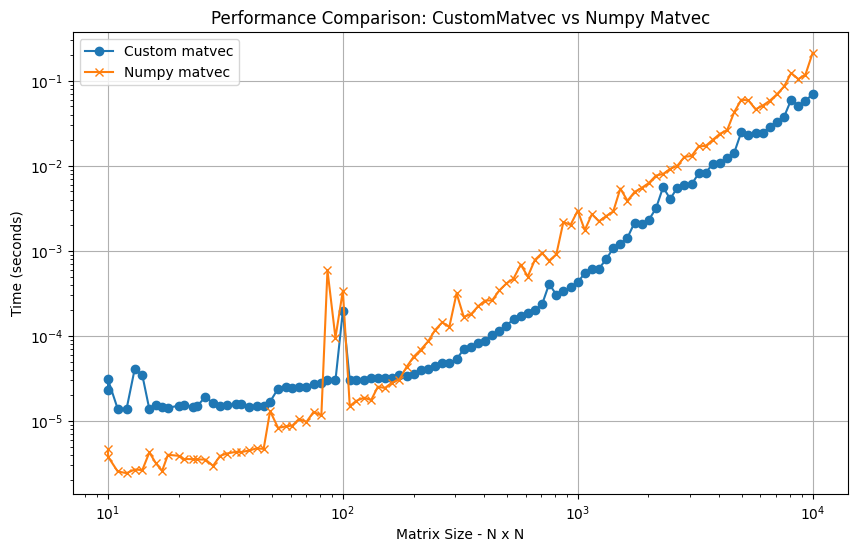

In [ ]:
# Run the timing tests
measure_matvec2()

The Custom Matvec is superior here due to the fact it has a sparse solver structure after 100 x 100 matrices. By computing only the upper left diagonal and the lower right diagonal then using these to compute the result as the other entires will be zero, time is saved. Contrastingly, the Numpy function wastes time calculating lots of irrelevant results as the matrix structure only really depends on the opposing diagonal structures. This creates the faster function.